# MÓDULOS UTILIZADOS

Pandas: esta biblioteca ayuda a cargar el marco de datos en un formato de matriz 2D y tiene múltiples funciones para realizar tareas de análisis de una sola vez.

Numpy: las matrices Numpy son muy rápidas y pueden realizar grandes cálculos en muy poco tiempo. Matplotlib: esta biblioteca se utiliza para dibujar visualizaciones.

Sklearn: este módulo contiene varias bibliotecas con funciones preimplementadas para realizar tareas desde el preprocesamiento de datos hasta el desarrollo y la evaluación de modelos.

OpenCV: esta es una biblioteca de código abierto enfocada principalmente en el procesamiento y manejo de imágenes.

Tensorflow: esta es una biblioteca de código abierto que se utiliza para el aprendizaje automático y la inteligencia artificial y proporciona una gama de funciones para lograr funcionalidades complejas con una sola línea de código.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import load_img
from keras import layers

import warnings
warnings.filterwarnings('ignore')

# VISUALIZACIÓN DE DATOS

En esta sección, se intenta comprender y visualizar las imágenes procesadas por medio de Matlab

In [ ]:
pathTest = '/content/drive/MyDrive/EMG/Test'
classesTest = os.listdir(pathTest)
classesTest

['Test_PreF', 'Test_F']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pathTrain = '/content/drive/MyDrive/EMG/Train'
classesTrain = os.listdir(pathTrain)
classesTrain

['Train_F', 'Train_PreF']

# CLASES

El siguiente resultado puede variar cada vez que se ejecuta porque el código se implementó de tal manera que mostrará diferentes imágenes cada vez que vuelva a ejecutar el código.

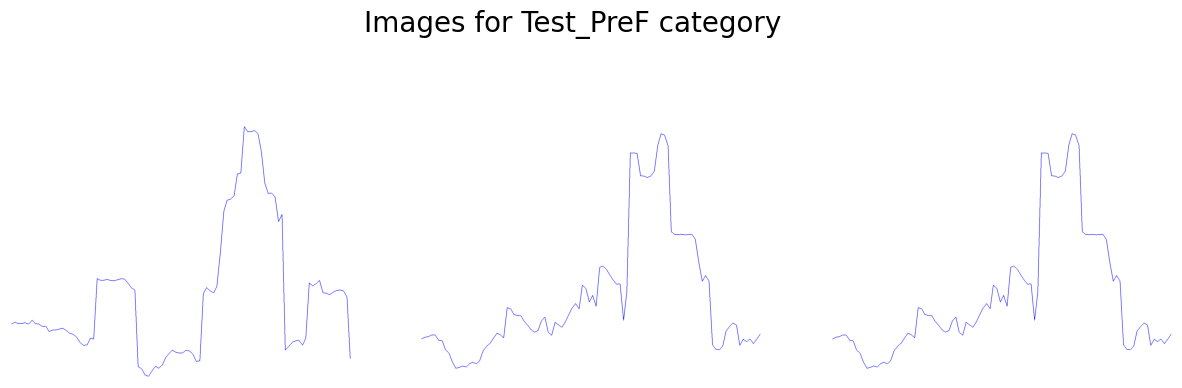

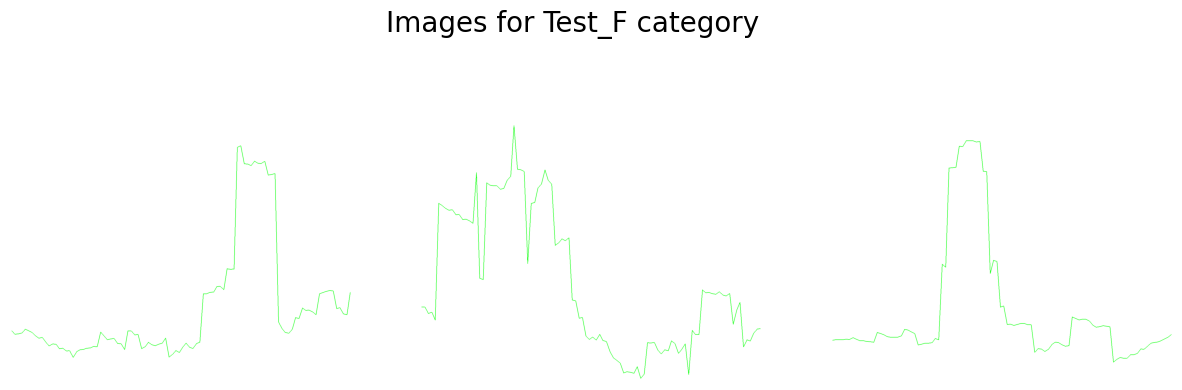

In [ ]:
pathTest = '/content/drive/MyDrive/EMG/Test'

for cat in classesTest:
    image_dir = f'{pathTest}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{pathTest}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

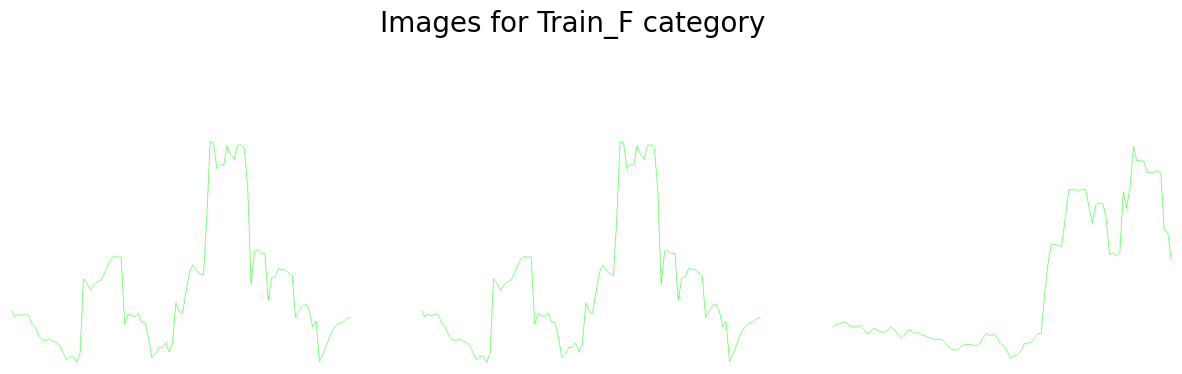

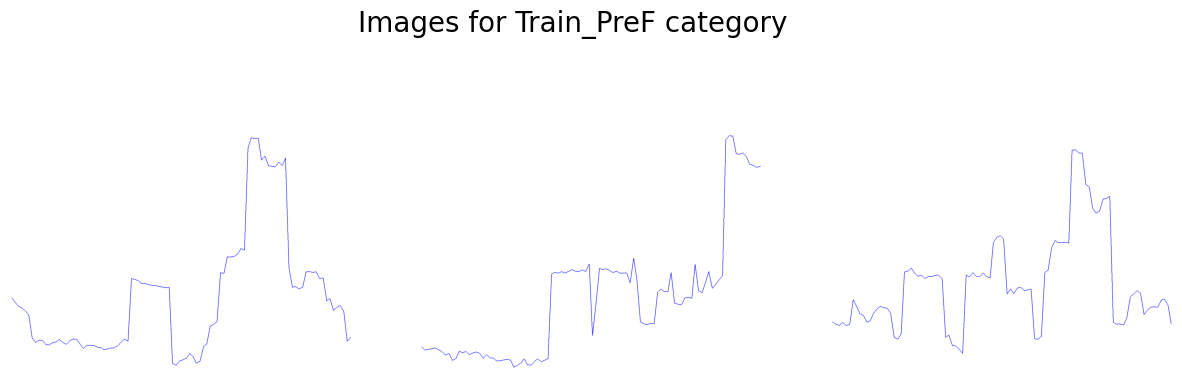

In [ ]:
pathTrain = '/content/drive/MyDrive/EMG/Train'

for cat in classesTrain:
    image_dir = f'{pathTrain}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{pathTrain}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [ ]:
pathImages = ['/content/drive/MyDrive/EMG/Train/Train_F',
             '/content/drive/MyDrive/EMG/Train/Train_PreF']

def load_images(pathImages = pathImages, n=18):#36
    # Load the images from disk.
    images = []
    for i in range(len(pathImages)):
        images_ = [cv2.imread(pathImages[i]+'/'+path) for path in os.listdir(pathImages[i])[:int(n/4)]]
        images.append(images_)
    # Convert to a numpy array and return it.
    sample = np.asarray(images)
    return sample

# FUNCIÓN PARA MOSTRAR IMÁGENES DE ENTRENAMIENTO DE EJEMPLO

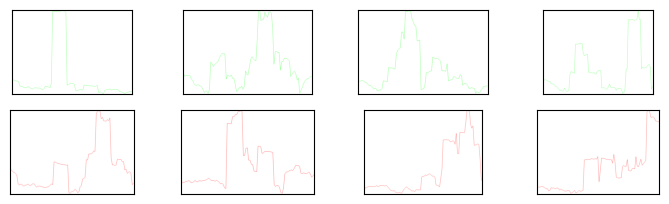

In [ ]:
sample = load_images()
fig = plt.figure(figsize=(20,5))
l = 1
shapes = []
for i in range(sample.shape[0]):
    for m in range(sample.shape[1]):
        ax = fig.add_subplot(4,9,m+l,xticks = [], yticks = [])
        ax.imshow(np.squeeze(sample[i,m]))
        shapes.append(sample[i,m].shape)
    l +=9

# PREPROCESAMIENTO DE IMAGEN

Todas las imágenes deben tener una escala similar, de lo contrario, el programa tardará mucho más en converger.

In [ ]:
image_shape = (125,125,3)
N_CLASSES = 2
BATCH_SIZE = 2

train_datagen = ImageDataGenerator(dtype='float32', rescale= 1.0/255.)
train_generator = train_datagen.flow_from_directory(pathTrain,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (125,125),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(pathTest,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (125,125),
                                                   class_mode = 'categorical')

Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


# ARQUITECTURA DEL MODELO

Se implementa un modelo secuencial que contendrá las siguientes partes:

* Tres capas convolucionales seguidas de capas MaxPooling.
* La capa Flatten para aplanar la salida de la capa convolucional.
* Entonces tendremos dos capas completamente conectadas seguidas por la salida de la capa aplanada.
* Hemos incluido algunas capas de BatchNormalization para permitir un entrenamiento estable y rápido y una capa de abandono antes de la capa final para evitar cualquier posibilidad de sobreajuste.
* La capa final es la capa de salida que genera probabilidades blandas para las tres clases.

In [ ]:
model = keras.models.Sequential([
    layers.Conv2D(filters=16,
                  kernel_size=(2, 2),
                  activation='relu',
                  input_shape=(125, 125, 3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=34,
                  kernel_size=(2, 2),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(4, 4),

    layers.Conv2D(filters=68,
                  kernel_size=(2, 2),
                  activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(2, activation='softmax')
])

# RESUMEN DE LA ARQUITECTURA DEL MODELO

Podemos ver el cambio en la forma de la imagen de entrada después de pasar por diferentes capas. El modelo CNN que hemos desarrollado contiene 121016 de parámetros. Esta cantidad de parámetros y la complejidad del modelo es lo que ayuda a lograr un modelo de alto rendimiento que se utiliza en aplicaciones de la vida real.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 34)        2210      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 34)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 68)        9316      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 68)          0

# CAMBIOS EN LA FORMA DE LA IMAGEN DE ENTRADA

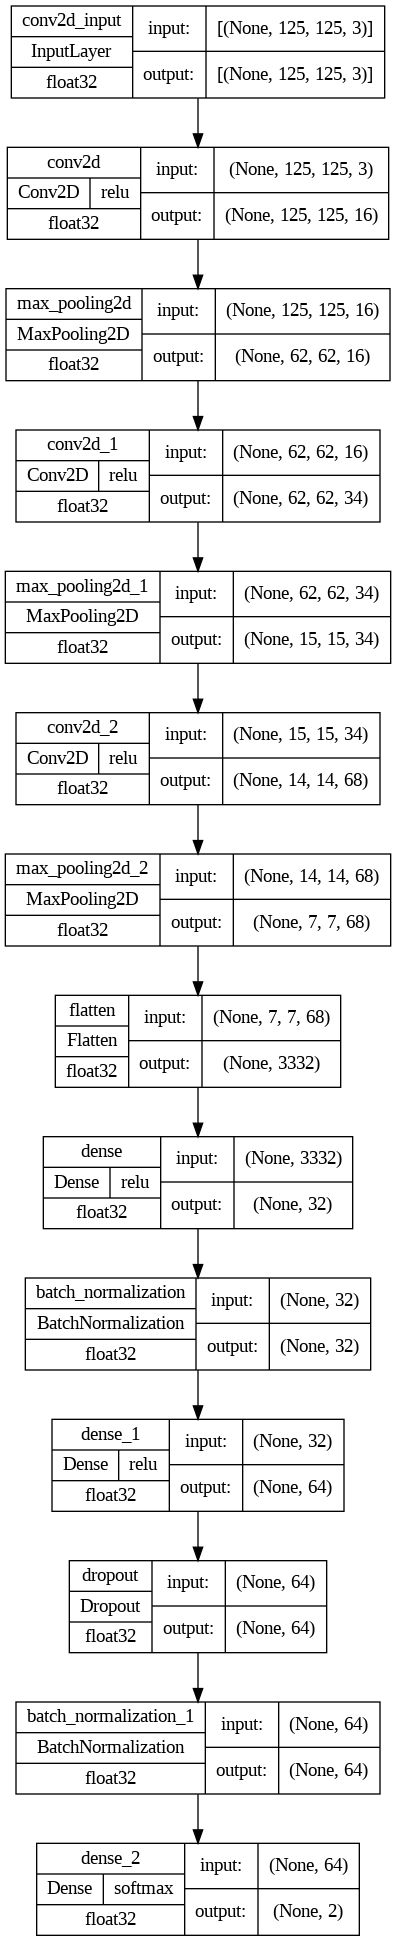

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

# COMPILACIÓN

Al compilar un modelo, se proporciona estos tres parámetros esenciales:

* Optimizer: Este es el método que ayuda a optimizar la función de costo mediante el uso de descenso de gradiente.
* Loss: La función de pérdida por la cual monitoreamos si el modelo está mejorando con el entrenamiento o no.
* Metrics: Esto ayuda a evaluar el modelo al predecir el entrenamiento y los datos de validación.

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
    #optimizer = tf.keras.optimizers.Adam(0.1),
    #loss = 'mean_squared_error',
    #metrics = ['accuracy']
)

# ENTRENAMIENTO, VALIDACIÓN Y PRUEBA DE DATAFRAME

In [ ]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, ts_dir):

    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, test_df

In [ ]:
def create_gens(train_df, test_df, batch_size):
    img_size = (125, 125)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, test_gen

In [ ]:
train_dir = '/content/drive/MyDrive/EMG/Train'
test_dir = '/content/drive/MyDrive/EMG/Test'

train_df, test_df = create_df(train_dir, test_dir)

train_gen, test_gen = create_gens(train_df, test_df, 20)#25


Found 40 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.


# COMPILACIÓN DEL MODELO

In [ ]:
import tensorflow as tf
model.compile(optimizer="adam", loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

#early stopping function
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

# ENTRENAMIENTO

In [ ]:
#fit the model
histroy=model.fit(train_gen,
    validation_data = test_gen,
    #callbacks=[early],
    epochs = 20)

Epoch 1/20
2/2 [==============================] - 3s 2s/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0672 - val_accuracy: 0.9500
Epoch 2/20
2/2 [==============================] - 3s 2s/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.0532 - val_accuracy: 0.9750
Epoch 3/20
2/2 [==============================] - 2s 1s/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0457 - val_accuracy: 1.0000
Epoch 4/20
2/2 [==============================] - 2s 1s/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0386 - val_accuracy: 1.0000
Epoch 5/20
2/2 [==============================] - 2s 1s/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.0357 - val_accuracy: 1.0000
Epoch 6/20
2/2 [==============================] - 2s 1s/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 0.0346 - val_accuracy: 1.0000
Epoch 7/20
2/2 [==============================] - 2s 1s/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0340 - val_accuracy: 1.0000
Epoch 8/20
2/2 [=========================

# VISUALIZACIÓN DEL ENTRENAMIENTO Y PRECISIÓN DE VALIDACIÓN CON CADA EPOCH

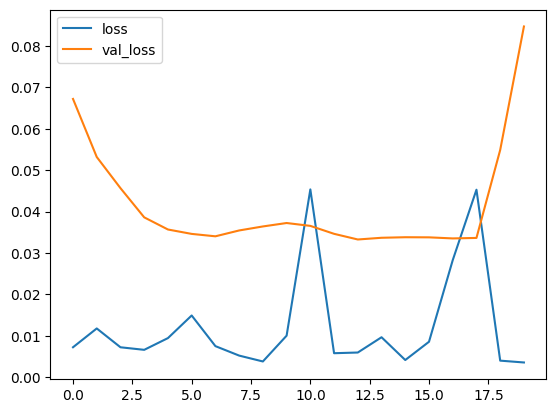

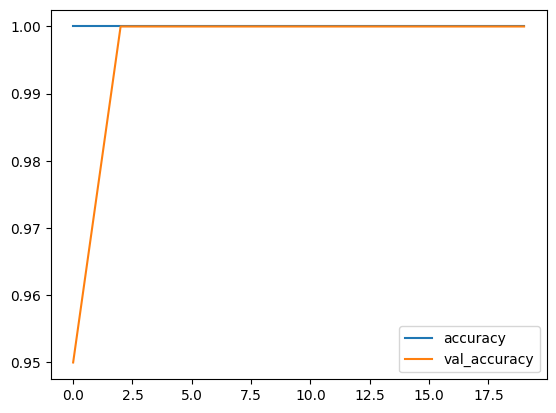

In [ ]:
history_df = pd.DataFrame(histroy.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

# EVALUACIÓN DEL MODELO

Para este propósito, primero se prede la clase de los datos de validación usando este modelo y luego se compara la salida con las etiquetas verdaderas

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


# MATRIZ DE CONFUSIÓN

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
target_names = ['Fatiga', 'PreFatiga']

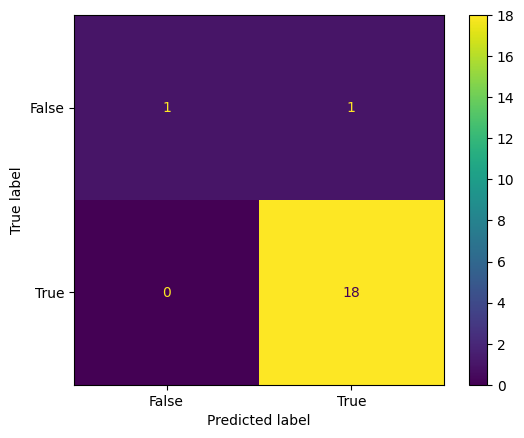

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

# Generar datos de ejemplo de etiquetas reales y predichas
actual = numpy.random.binomial(1,.9,size = 20)
predicted = numpy.random.binomial(1,.9,size = 20)

# Crear la matriz de confusión utilizando sklearn
confusion_matrix = metrics.confusion_matrix(actual, predicted)

# Crear la visualización de la matriz de confusión
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

# Graficar la matriz de confusión
cm_display.plot()
plt.show()

La Matriz de Confusión creada tiene cuatro cuadrantes diferentes:

* Negativo verdadero (cuadrante superior izquierdo)
* Falso positivo (cuadrante superior derecho)
* Falso negativo (cuadrante inferior izquierdo)
* Verdadero positivo (cuadrante inferior derecho)
Verdadero significa que los valores se predijeron con precisión, Falso significa que hubo un error o una predicción incorrecta.

# INFORME DE CLASIFICACIÓN PARA LOS DATOS DE VALIDACIÓN

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

              precision    recall  f1-score   support

      Fatiga       1.00      1.00      1.00        20
   PreFatiga       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



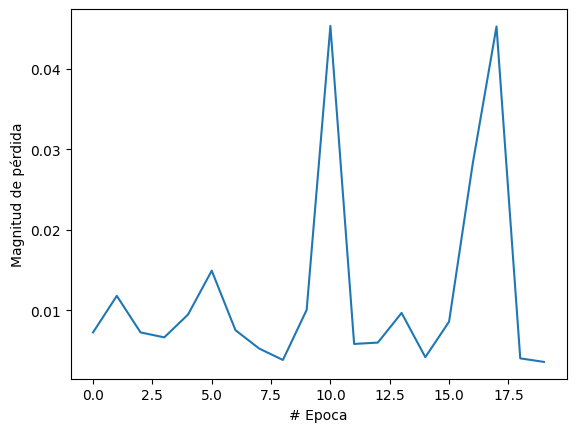

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(histroy.history["loss"])

# Prueba 1: Fatiga

1/1 [==============================] - 0s 34ms/step
[[0.9952638  0.00473614]]
La gráfica se refiere a: Fatiga


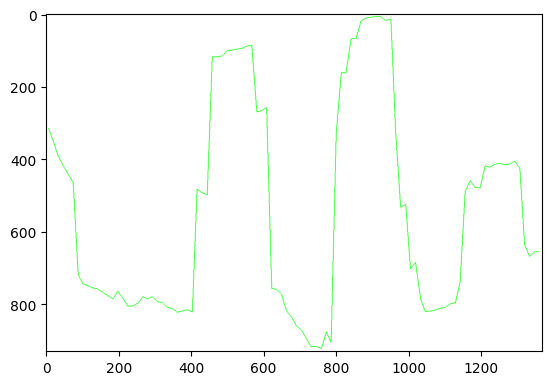

In [ ]:
import tensorflow as tf
image_path = '/content/drive/MyDrive/EMG/Test/Test_F/End-1.png'
image_loaded = tf.keras.utils.load_img(image_path)
image_loaded
image = tf.keras.preprocessing.image.img_to_array(image_loaded)
image_resized = tf.image.resize(image_loaded, (125, 125))
image = np.expand_dims(image_resized,axis=0)
ypred = model.predict(image)
print(ypred)
a=np.argmax(ypred,1)
if a==0:
      op="Fatiga"
else:
      op="Prefatiga"
plt.imshow(image_loaded)
print("La gráfica se refiere a: "+str(op))

# Prueba 2: Prefatiga

1/1 [==============================] - 0s 79ms/step
[[0.1613958 0.8386042]]
La gráfica se refiere a: Prefatiga


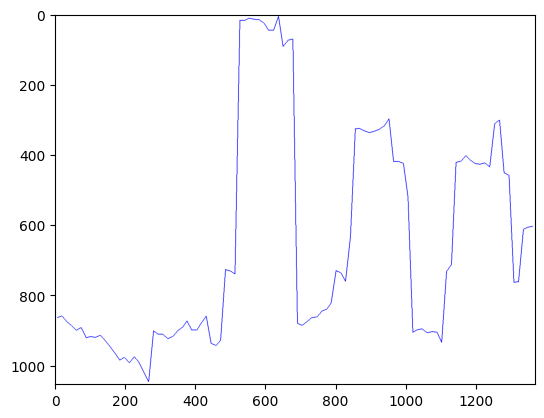

In [ ]:
import tensorflow as tf
image_path = '/content/drive/MyDrive/EMG/Test/Test_PreF/Init-1.png'
image_loaded = tf.keras.utils.load_img(image_path)
image_loaded
image = tf.keras.preprocessing.image.img_to_array(image_loaded)
image_resized = tf.image.resize(image_loaded, (125, 125))
image = np.expand_dims(image_resized,axis=0)
ypred = model.predict(image)
print(ypred)
a=np.argmax(ypred,1)
if a==0:
      op="Fatiga"
else:
      op="Prefatiga"
plt.imshow(image_loaded)
print("La gráfica se refiere a: "+str(op))

# Prueba 3: Fatiga

1/1 [==============================] - 0s 37ms/step
[[9.999255e-01 7.448907e-05]]
La gráfica se refiere a: Fatiga


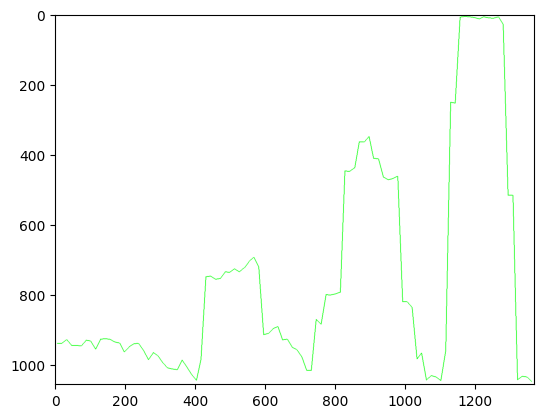

In [ ]:
import tensorflow as tf
image_path = '/content/drive/MyDrive/EMG/Test/Test_F/End-15.png'
image_loaded = tf.keras.utils.load_img(image_path)
image_loaded
image = tf.keras.preprocessing.image.img_to_array(image_loaded)
image_resized = tf.image.resize(image_loaded, (125, 125))
image = np.expand_dims(image_resized,axis=0)
ypred = model.predict(image)
print(ypred)
a=np.argmax(ypred,1)
if a==0:
      op="Fatiga"
else:
      op="Prefatiga"
plt.imshow(image_loaded)
print("La gráfica se refiere a: "+str(op))

# Prueba 4: Prefatiga

1/1 [==============================] - 0s 121ms/step
[[0.05931439 0.9406856 ]]
La gráfica se refiere a: Prefatiga


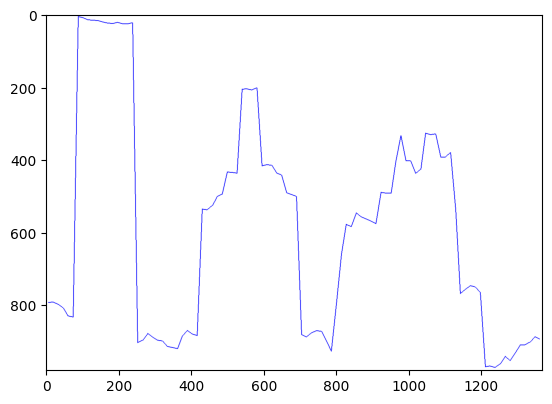

In [ ]:
import tensorflow as tf
image_path = '/content/drive/MyDrive/EMG/Test/Test_PreF/Init-2.png'
image_loaded = tf.keras.utils.load_img(image_path)
image_loaded
image = tf.keras.preprocessing.image.img_to_array(image_loaded)
image_resized = tf.image.resize(image_loaded, (125, 125))
image = np.expand_dims(image_resized,axis=0)
ypred = model.predict(image)
print(ypred)
a=np.argmax(ypred,1)
if a==0:
      op="Fatiga"
else:
      op="Prefatiga"
plt.imshow(image_loaded)
print("La gráfica se refiere a: "+str(op))

# Prueba 5: Fatiga

1/1 [==============================] - 0s 42ms/step
[[0.99846065 0.00153931]]
La gráfica se refiere a: Fatiga


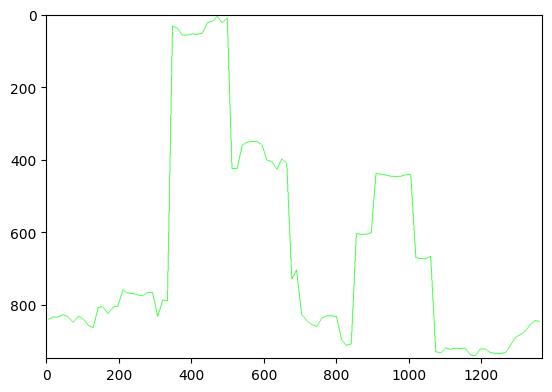

In [ ]:
import tensorflow as tf
image_path = '/content/drive/MyDrive/EMG/Test/Test_F/End-8.png'
image_loaded = tf.keras.utils.load_img(image_path)
image_loaded
image = tf.keras.preprocessing.image.img_to_array(image_loaded)
image_resized = tf.image.resize(image_loaded, (125, 125))
image = np.expand_dims(image_resized,axis=0)
ypred = model.predict(image)
print(ypred)
a=np.argmax(ypred,1)
if a==0:
      op="Fatiga"
else:
      op="Prefatiga"
plt.imshow(image_loaded)
print("La gráfica se refiere a: "+str(op))